# Running simulation AKE

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import mdtraj as md
from openmm.app.topology import Topology
from openmm.app.simulation import Simulation
from openmm.app.dcdreporter import DCDReporter
from openmm.app.statedatareporter import StateDataReporter
import openmm.unit as u
import openmm as mm
import openmm.openmm as openmm
import pyemma.coordinates as coor
import pyemma

In [2]:
# Force field parametrization constants
ATOM_MASS = 1.0         # a.u.
BOND_STRENGTH = 20000.0 # kJ/(nm**2 mol)
ANGLE_STRENGTH = 40.0   # kJ/(mol rad**2)
NONNATIVE_SIGMA = 0.4   # nm


# 1) Topology and contact map

## 1.1. Contact map for 4AKE and 1AKE

In [3]:
# We download the files 1AKE and 4AKE with only the first chain 

pdb_file_1AKE= '1ake_input_smog.pdb'  
pdb_file_4AKE = '4ake_input_smog.pdb'   

# We download the files
AKE_1_structure = md.load(pdb_file_1AKE) # Closed form
AKE_4_structure = md.load(pdb_file_4AKE) # Open form

# We download the native contacts file
native_contacts_1AKE_file = '1ake_contact_map.txt' 
native_contacts_4AKE_file = '4ake_contact_map.txt' 

native_contacts_1AKE  = np.loadtxt(native_contacts_1AKE_file,dtype=int)
native_contacts_4AKE  = np.loadtxt(native_contacts_4AKE_file,dtype=int)

# We select only the atom indexes
selected_columns_1AKE = native_contacts_1AKE[:, [1, 3]] 
selected_columns_4AKE = native_contacts_4AKE[:, [1, 3]]
print(selected_columns_1AKE.shape)
print(selected_columns_4AKE.shape)


(635, 2)
(598, 2)


All-Atom Calpha:

Considers a contact between two residues formed if any atom-atom contact is formed between the residues. 
Outputs the residue level contact map with the atom numbering of the Calpha atoms.

Format: Chain i Calpha_Atom k Chain j Calpha_Atom l

In our case: Chain i = Chain j = 1

Structure:
1 CA_k 1 CA_l

## 1.2. Create topology for 4AKE and 1AKE

In [4]:
# We create files with only Calpha
ca_atoms_ndx_AKE1 = AKE_1_structure.top.select('name CA')

ca_structure_AKE1 = AKE_1_structure.atom_slice(ca_atoms_ndx_AKE1)
ca_structure_AKE1.save('pdb_file_1AKE_Calpha.pdb')
print(list(ca_structure_AKE1.top.residues))

ca_atoms_ndx_AKE4 = AKE_4_structure.top.select('name CA')
ca_structure_AKE4 = AKE_4_structure.atom_slice(ca_atoms_ndx_AKE4)
ca_structure_AKE4.save('pdb_file_4AKE_Calpha.pdb')


# We create a topology and we visualize the structure of the protein in both states

topology_AKE1= ca_structure_AKE1.top.to_openmm()
n_atoms_AKE1 = topology_AKE1.getNumAtoms()
print("Topology 1AKE: ", topology_AKE1)

topology_AKE4= ca_structure_AKE4.top.to_openmm()
n_atoms_AKE4 = topology_AKE4.getNumAtoms()
print("Topology 4AKE: ", topology_AKE4)

# We add the bonds
atoms_AKE4 = list(topology_AKE4.atoms())
for ndx in range(n_atoms_AKE4-1):
        topology_AKE4.addBond(atoms_AKE4[ndx], atoms_AKE4[ndx+1])
print(topology_AKE4)

atoms_AKE1 = list(topology_AKE1.atoms())
for ndx in range(n_atoms_AKE1-1):
        topology_AKE1.addBond(atoms_AKE1[ndx], atoms_AKE1[ndx+1])
print(topology_AKE1)

n_Calpha=n_atoms_AKE4 # n_atoms4AKE=n_atoms1AKE as expected

[MET1, ARG2, ILE3, ILE4, LEU5, LEU6, GLY7, ALA8, PRO9, GLY10, ALA11, GLY12, LYS13, GLY14, THR15, GLN16, ALA17, GLN18, PHE19, ILE20, MET21, GLU22, LYS23, TYR24, GLY25, ILE26, PRO27, GLN28, ILE29, SER30, THR31, GLY32, ASP33, MET34, LEU35, ARG36, ALA37, ALA38, VAL39, LYS40, SER41, GLY42, SER43, GLU44, LEU45, GLY46, LYS47, GLN48, ALA49, LYS50, ASP51, ILE52, MET53, ASP54, ALA55, GLY56, LYS57, LEU58, VAL59, THR60, ASP61, GLU62, LEU63, VAL64, ILE65, ALA66, LEU67, VAL68, LYS69, GLU70, ARG71, ILE72, ALA73, GLN74, GLU75, ASP76, CYS77, ARG78, ASN79, GLY80, PHE81, LEU82, LEU83, ASP84, GLY85, PHE86, PRO87, ARG88, THR89, ILE90, PRO91, GLN92, ALA93, ASP94, ALA95, MET96, LYS97, GLU98, ALA99, GLY100, ILE101, ASN102, VAL103, ASP104, TYR105, VAL106, LEU107, GLU108, PHE109, ASP110, VAL111, PRO112, ASP113, GLU114, LEU115, ILE116, VAL117, ASP118, ARG119, ILE120, VAL121, GLY122, ARG123, ARG124, VAL125, HIS126, ALA127, PRO128, SER129, GLY130, ARG131, VAL132, TYR133, HIS134, VAL135, LYS136, PHE137, ASN138, PRO

## 1.3. Microscopic Mixing for 1AKE and 4AKE

In [5]:
class MicroscopicMixing:

    def compare_matrices(self, matrix_a, matrix_b):
         # Concatenate matrices vertically, excluding duplicates from matrix_b
        matrix_c = np.vstack([line_a for line_a in matrix_a] + [line_b for line_b in matrix_b if not any(np.array_equal(line_b, line_a) for line_a in matrix_a)])
        return matrix_c # formed by stacking unique rows from both input matrices vertically.

    def custom_sort(self, matrix):
        def sort_key(line):
            return (line[0], line[1])  # Sort by the first element, then by the second element
        sorted_matrix = sorted(matrix, key=sort_key)
        return sorted_matrix

    def find_unique_numbers(self, matrix):
        # Flatten the matrix and extract unique numbers, then sort them
        flat_matrix = [element for row in matrix for element in row]
        unique_numbers = list(set(flat_matrix))
        sorted_unique_numbers = sorted(unique_numbers)
        return sorted_unique_numbers

    def create_mapping(self, vector_a, vector_b):
        # Create a mapping dictionary between elements of two vectors
        mapping = {}
        for element_a, element_b in zip(vector_a, vector_b):
            mapping[element_a] = element_b
        return mapping

    def apply_mapping(self, matrix, mapping):
         # Apply the mapping dictionary to each element in the matrix
        num_rows = len(matrix)
        num_cols = len(matrix[0])
        result_matrix = [[0] * num_cols for _ in range(num_rows)]
        for i in range(num_rows):
            for j in range(num_cols):
                original_element = matrix[i][j]
                mapped_element = mapping.get(original_element, original_element)
                result_matrix[i][j] = mapped_element
        return result_matrix
    
    def extract_added_lines(self, matrix_a, matrix_b):
        # Convert rows of matrices to frozensets for set operations
        set_a = {tuple(row) for row in matrix_a}
        set_b = {tuple(row) for row in matrix_b}

        # Find added lines by subtracting set_a from set_b
        added_lines_set = set_b - set_a

        # Convert back to numpy array with dtype=object and reshape to have 2 columns
        added_lines = np.array(list(added_lines_set), dtype=object).reshape(-1, 2)

        # Sort the added lines first by the first column, then by the second column
        added_lines = added_lines[np.lexsort((added_lines[:, 1], added_lines[:, 0]))]

        return added_lines

In [6]:
micro_mixing = MicroscopicMixing()

# The contact maps for 4AKE and 1AKE have the original contact map indexes before extracting only the Calpha atoms. Therefore, we need to renumber all of them.
# 4AKE:
native_contacts_4AKE_indices = np.array(micro_mixing.find_unique_numbers(selected_columns_4AKE))
#indices_4AKE = np.array(list(range(len(native_contacts_4AKE_indices))))
indices_4AKE = np.array(list(range(n_Calpha)))
mapping_4AKE = micro_mixing.create_mapping(native_contacts_4AKE_indices, indices_4AKE)
native_contacts_4AKE_mapped = micro_mixing.apply_mapping(selected_columns_4AKE, mapping_4AKE)
np.savetxt('native_contacts_4AKE_mapped.txt', native_contacts_4AKE_mapped, fmt='%d')

# 1AKE:
native_contacts_1AKE_indices = np.array(micro_mixing.find_unique_numbers(selected_columns_1AKE))
indices_1AKE = np.array(list(range(n_Calpha)))
mapping_1AKE = micro_mixing.create_mapping(native_contacts_1AKE_indices, indices_1AKE)
native_contacts_1AKE_mapped = micro_mixing.apply_mapping(selected_columns_1AKE, mapping_1AKE)
np.savetxt('native_contacts_1AKE_mapped.txt', native_contacts_1AKE_mapped, fmt='%d')


# Now we do the microscopic mixing of contacts 
# Starting in 4AKE
native_contacts_start_4AKE = micro_mixing.compare_matrices(native_contacts_4AKE_mapped, native_contacts_1AKE_mapped) #This is contacts_matrix_1 with the inclusion of contacts 
#from contacts_matrix_2 that do not overlap with those present in contacts_matrix_1
native_contacts_start_4AKE = np.array(micro_mixing.custom_sort(native_contacts_start_4AKE)) # We need to sort the contacts in ascending order 
np.savetxt('native_contacts_start_4AKE.txt', native_contacts_start_4AKE, fmt='%d')

# Starting in 1AKE
native_contacts_start_1AKE = micro_mixing.compare_matrices(native_contacts_1AKE_mapped, native_contacts_4AKE_mapped) #This is contacts_matrix_1 with the inclusion of contacts 
#from contacts_matrix_2 that do not overlap with those present in contacts_matrix_1
native_contacts_start_1AKE = np.array(micro_mixing.custom_sort(native_contacts_start_1AKE)) # We need to sort the contacts in ascending order 
np.savetxt('native_contacts_start_1AKE.txt', native_contacts_start_1AKE, fmt='%d')



In [7]:
# We want to look at the different pairs

# Starting in 4KE
diff_pairs_start_4AKE = micro_mixing.extract_added_lines(np.array(native_contacts_4AKE_mapped), np.array(native_contacts_start_4AKE))
# Starting in 1KE
diff_pairs_start_1AKE = micro_mixing.extract_added_lines(np.array(native_contacts_1AKE_mapped), np.array(native_contacts_start_1AKE))

print("diff_pairs_start_4AKE", diff_pairs_start_4AKE, len(diff_pairs_start_4AKE))
print("diff_pairs_start_1AKE", diff_pairs_start_1AKE, len(diff_pairs_start_1AKE))

diff_pairs_start_4AKE [[1 77]
 [4 86]
 [5 10]
 [6 107]
 [6 174]
 [9 122]
 [11 16]
 [12 27]
 [12 87]
 [13 27]
 [13 129]
 [14 131]
 [14 137]
 [16 25]
 [16 83]
 [17 27]
 [17 129]
 [17 130]
 [17 131]
 [19 108]
 [21 205]
 [26 78]
 [27 128]
 [27 129]
 [28 75]
 [28 85]
 [31 36]
 [31 52]
 [31 83]
 [31 84]
 [31 87]
 [32 39]
 [32 83]
 [32 126]
 [32 128]
 [32 129]
 [33 44]
 [34 44]
 [34 45]
 [34 63]
 [35 155]
 [35 156]
 [35 157]
 [37 41]
 [39 126]
 [42 47]
 [43 62]
 [45 52]
 [45 62]
 [45 66]
 [52 157]
 [52 162]
 [52 166]
 [53 156]
 [53 157]
 [53 159]
 [53 162]
 [54 161]
 [54 162]
 [54 165]
 [55 157]
 [55 162]
 [55 165]
 [55 166]
 [55 169]
 [56 169]
 [57 87]
 [57 88]
 [57 169]
 [57 173]
 [57 174]
 [58 91]
 [59 64]
 [63 68]
 [63 84]
 [68 94]
 [71 75]
 [71 82]
 [75 80]
 [82 100]
 [84 91]
 [85 94]
 [86 174]
 [87 92]
 [87 166]
 [87 170]
 [88 174]
 [89 94]
 [90 173]
 [93 98]
 [95 101]
 [107 182]
 [108 170]
 [112 170]
 [114 197]
 [118 199]
 [119 123]
 [119 159]
 [120 133]
 [120 134]
 [120 159]
 [123 133

## 2) Define the interactions

In [8]:
def add_nonbonded_interactions(ca_structure_init, ca_structure_end, system, native_contacts, diff_pairs):
    """
    Add nonbonded interactions to OpenMM System object
    
    Parameters
    ----------
    ca_structure :  mdtraj.Trajectory object
        Trajectory that contains native structure for the CG model.
        If more than one frame provided, only the first frame will be used
        and the rest will be discarded. 
    
    native_contacts : numpy ndarray, dtype int
        A Mx2 numpy array. Each row  represents a pair of residues that are in contact in the 
        native structure
        
    system : openmm.openmm.System object
        Object to which forces should be added
        
    Returns
    -------
    system : openmm.openmm.System object
       Modified system
    
    """
    # Add nonbonded interaction 
    n_atoms = ca_structure_init.top.n_atoms
    nonbonded_force = mm.openmm.CustomNonbondedForce("(sigma/r)^12; sigma=sqrt(sigma1*sigma2)")
    nonbonded_force.addPerParticleParameter("sigma")
    for i in range(n_atoms):
        nonbonded_force.addParticle([NONNATIVE_SIGMA])
        
    # Exclude 1-2, 1-3 and 1-4 interactions:
    # Bond cutoff=3: atoms separated by 3 bonds or less are excluded
    nonbonded_force.createExclusionsFromBonds(bonds=[[i, i+1] for i in range(n_atoms-1)], bondCutoff=3)
            
    # Add native interaction
    native_force = mm.openmm.CustomBondForce("5.0*((rnot/r)^12) - 6.0*((rnot/r)^10)")
    native_force.addPerBondParameter("rnot")
    distances=compute_distances(ca_structure_init, ca_structure_end, native_contacts, diff_pairs)
    #distances_MD =  md.compute_distances(ca_structure_init, native_contacts)[0]

    for ndx, contact in enumerate(native_contacts):
        # OpenMM does not work correctly with numpy objects, all scalars should be 
        # explicitly converted
        atom_1 = int(contact[0])
        atom_2 = int(contact[1])
        native_force.addBond(atom_1, atom_2, [float(distances[ndx])])
        nonbonded_force.addExclusion(atom_1, atom_2)
        
    # Add forces to the system
    system.addForce(nonbonded_force)
    system.addForce(native_force)
    return system 
                                     
def add_dihedral_interactions(ca_structure_init, ca_structure_end, system):

    n_atoms = ca_structure_init.top.n_atoms

    """
    Add dihedral interactions to OpenMM System object
    
    Parameters
    ----------
    ca_structure :  mdtraj.Trajectory object
        Trajectory that contains native structure for the CG model.
        If more than one frame provided, only the first frame will be used
        and the rest will be discarded. 
        
    system : openmm.openmm.System object
        Object to which forces should be added
        
    Returns
    -------
    system : openmm.openmm.System object
       Modified system

    """
    # Add dihedral angle potential. 
    atom_quadruples = [[i, i+1, i+2, i+3] for i in range(n_atoms - 3)]
    dihedrals = md.compute_dihedrals(ca_structure_init, atom_quadruples)[0] 
    dihedral_force = mm.openmm.PeriodicTorsionForce()
    for dihedral_ndx in range(n_atoms - 3):
        dihedral_1 = dihedrals[dihedral_ndx] + np.pi
        dihedral_2 = 3*(dihedrals[dihedral_ndx] + np.pi)
        dihedral_force.addTorsion(*atom_quadruples[dihedral_ndx], 1, dihedral_1, 1.0)
        dihedral_force.addTorsion(*atom_quadruples[dihedral_ndx], 3, dihedral_2, 0.5)
    system.addForce(dihedral_force)
    return system


def save_system(system, name='OpenMM_system.xml'):
    """
    Save OpenMM system object to a human readable xml file
    
    Parameters:
    ----------- 
    
    name : str, optional
        Name of the file, should end with .xml extension
        
    system : openmm.openmm.System object
    """
    with open(name, 'w') as f:
        system_xml = mm.XmlSerializer.serialize(system)
        f.write(system_xml) 
    return

def compute_distances(ca_structure_init, ca_structure_end, atom_pairs, diff_pairs):
    # Extract coordinates from the trajectories
    init_coords = ca_structure_init.xyz[0]
    end_coords = ca_structure_end.xyz[0]

    # Convert diff_pairs to a set of tuples for faster lookup
    diff_pairs_set = set(map(tuple, diff_pairs))

    # Initialize an array to store distances
    distances = []

    # Loop through atom pairs using enumerate to get both index and pair
    for n, pair in enumerate(atom_pairs):
        atom1, atom2 = pair

        # Check if the entire pair is in diff_pairs_set
        if (atom1, atom2) in diff_pairs_set or (atom2, atom1) in diff_pairs_set:
            # Use coordinates from ca_structure_end
            coord1 = end_coords[atom1, :]
            coord2 = end_coords[atom2, :]
        else:
            # Use coordinates from ca_structure_init
            coord1 = init_coords[atom1, :]
            coord2 = init_coords[atom2, :]

        # Calculate distance and store in distances array
        distances.append(np.linalg.norm(coord1 - coord2))        

    return distances

In [9]:
distances_our_function=np.array(compute_distances(ca_structure_AKE4, ca_structure_AKE1, native_contacts_start_4AKE, diff_pairs_start_4AKE))
distances_md_4AKE=np.array(md.compute_distances(ca_structure_AKE4, native_contacts_start_4AKE)[0])
distances_md_1AKE=np.array(md.compute_distances(ca_structure_AKE1, native_contacts_start_4AKE)[0])

np.savetxt('distances using new function.txt', distances_our_function)
np.savetxt('distances_md_4AKE using MD old function.txt', distances_md_4AKE)
np.savetxt('distances_md_1AKE using MD old function.txt', distances_md_1AKE)

# Our file with the distances (distances_our_function) should be equal to distances_md_4AKE except for the atoms in diff_pairs_start_4AKE, for which it should be equal to distances_md_1AKE


## 3) Simulation

In [10]:
class simulation_class:
    def __init__(self, xml_file):
        self.xml_file = xml_file
        self.system = None
    
    def create_system(self, n_atoms, ca_structure_init, ca_structure_end, native_contacts, diff_pairs):
        # Create system
        system = openmm.System()

        # Add particles with specified mass
        for atom_ndx in range(n_atoms):
            system.addParticle(ATOM_MASS)

        # Add center of mass motion remover
        cmm_remover = openmm.CMMotionRemover()
        system.addForce(cmm_remover)

        # Add bonds between consecutive Ca atoms. Need to know bond length in native structures
        atom_pairs = [[i, i + 1] for i in range(n_atoms - 1)]
        bond_distances = md.compute_distances(ca_structure_init, atom_pairs)[0]
        bond_force = openmm.HarmonicBondForce()
        for bond_ndx in range(n_atoms - 1):
            bond_force.addBond(*atom_pairs[bond_ndx], float(bond_distances[bond_ndx]), BOND_STRENGTH)
        system.addForce(bond_force)

        # Add angle potentials for each 3 consecutive Ca atoms. Need to know angles in native structures
        atom_triples = [[i, i + 1, i + 2] for i in range(n_atoms - 2)]
        angles = md.compute_angles(ca_structure_init, atom_triples)[0]
        angle_force = openmm.HarmonicAngleForce()
        for angle_ndx in range(n_atoms - 2):
            angle_force.addAngle(*atom_triples[angle_ndx], float(angles[angle_ndx]), ANGLE_STRENGTH)
        system.addForce(angle_force)

        system = add_dihedral_interactions(ca_structure_init, ca_structure_end, system)
        system = add_nonbonded_interactions(ca_structure_init, ca_structure_end, system, native_contacts, diff_pairs)
        return system

    def save_system(self, system):
        with open(self.xml_file, 'w') as f:
            f.write(openmm.XmlSerializer.serialize(system))

    def load_system(self):
        with open(self.xml_file, 'r') as f:
            xml_content = f.read()
            self.system = openmm.XmlSerializer.deserialize(xml_content)

    def print_forces(self):
        if self.system is not None:
            for force in self.system.getForces():
                print(force)
        else:
            print("System not loaded. Use load_system() first.")


In [11]:
# CG modeling parameters

TEMPERATURE = 80  # K,  modeling temperature
LENGTH = 100000   # ps,   simulation length
STEPSIZE = 0.002   # ps,  integration step

STRIDE = 5/STEPSIZE       # steps, record coordinates every STRIDE steps
FRICTION = 1        # 1/ps, friction coefficient for LangevinIntegrator.
n_steps = int(LENGTH/STEPSIZE)


In [12]:
# Simulation starting in 4AKE configuration

xml_file = '4AKE_system.xml'
system_4AKE_simulation = simulation_class(xml_file)

# Create system
system_4AKE = system_4AKE_simulation.create_system(n_Calpha, ca_structure_AKE4, ca_structure_AKE1, native_contacts_start_4AKE, diff_pairs_start_4AKE)

# Save system
system_4AKE_simulation.save_system(system_4AKE)



In [13]:
integrator = openmm.LangevinIntegrator(TEMPERATURE*u.kelvin, FRICTION/u.picosecond, STEPSIZE*u.picoseconds)
platform = openmm.Platform.getPlatformByName("CUDA")
simulation_AKE4= Simulation(topology_AKE4, system_4AKE, integrator, platform)
simulation_AKE4.context.setPositions(ca_structure_AKE4.xyz[0])
simulation_AKE4.reporters.append(md.reporters.XTCReporter('traj_AKE4.xtc', STRIDE))
#simulation_AKE4.reporters.append(mm.app.pdbreporter.PDBReporter('traj_AKE4.pdb', STRIDE))

simulation_AKE4.step(n_steps)

[0.7130698]
80
50000000


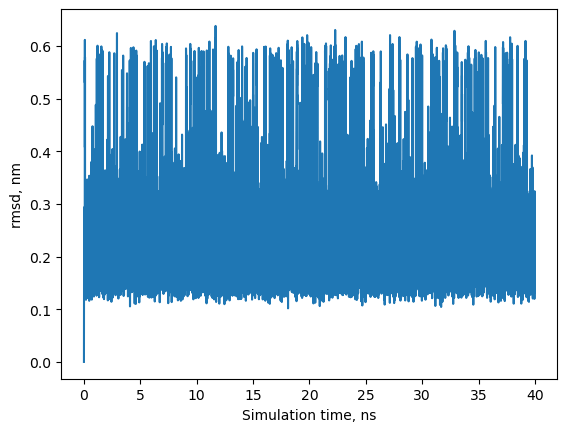

In [14]:
traj_AKE4= md.load('traj_AKE4.xtc',top='pdb_file_4AKE_Calpha.pdb')

rmsd = md.rmsd(traj_AKE4, traj_AKE4)
rmsd_both= md.rmsd(ca_structure_AKE4, ca_structure_AKE1)
print(rmsd_both)
plt.plot([STEPSIZE*i for i in range(len(rmsd))],rmsd)
plt.xlabel('Simulation time, ns')
plt.ylabel('rmsd, nm')
print(TEMPERATURE)
print(n_steps)

In [15]:
# This is a simplified option
def get_fraction_native_contacts(traj, native_contacts, cutoff=1.15):
    """
    Calculate fraction of frames in trajectory `traj`, 
    """
    distances = md.compute_distances(traj, native_contacts)
    contact_formed = np.where(distances < cutoff, 1, 0)
    num_of_contacts = np.sum(contact_formed, axis=1)
    fraction_of_contacts = num_of_contacts/contact_formed.shape[1]
    return(fraction_of_contacts)


Text(0, 0.5, 'Q')

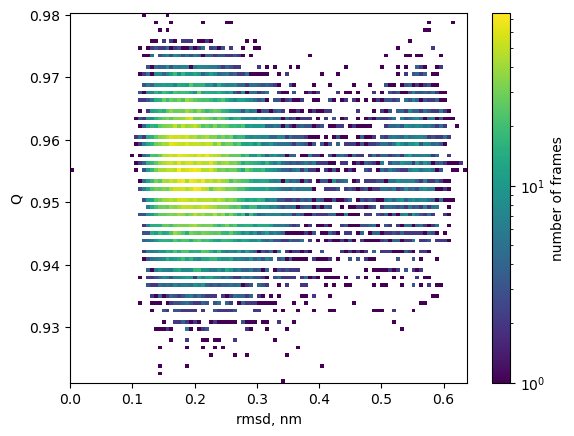

In [16]:
frac_native_4AKE = get_fraction_native_contacts(traj_AKE4, native_contacts_start_4AKE)
fig, ax = plt.subplots()
counts, xedges, yedges, im = ax.hist2d(rmsd, frac_native_4AKE, bins=100,norm=plt.matplotlib.colors.LogNorm())
cb = fig.colorbar(im, ax=ax)
cb.set_label('number of frames')

plt.xlabel('rmsd, nm')
#plt.ylim(0, 1)
plt.ylabel('Q')

OSError: No such file: 4ake_input_smog.pdb_Calpha.pdb

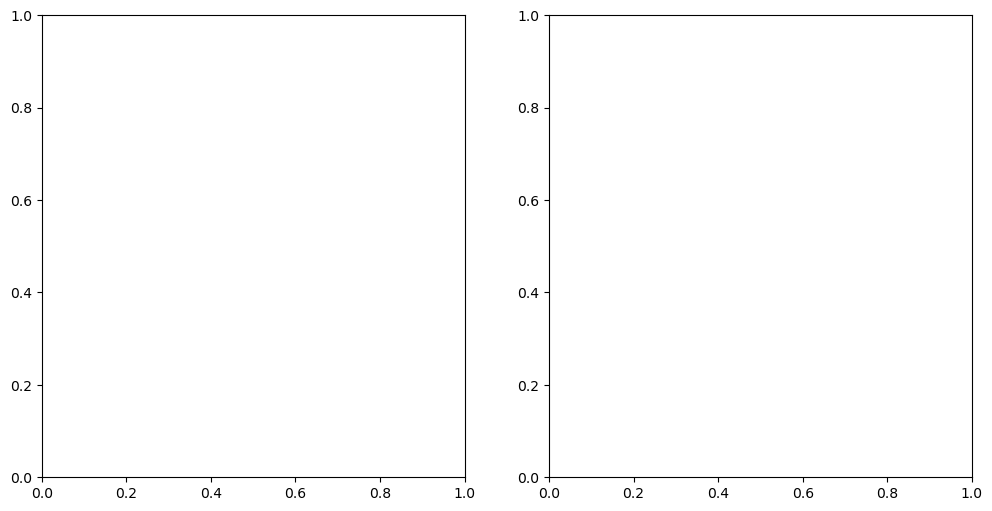

In [17]:
# Task 3: Choice of collective coordinates. 
fig, ax = plt.subplots(1,2, figsize=(12,6))
feat = coor.featurizer(f'4ake_input_smog.pdb_Calpha.pdb') # featurizer object
feat.add_distances_ca() # use c-alpha distances in TICA
ticalag_time = 10
inp = coor.source('traj_AKE4.xtc', feat, chunksize=1000) # create an input object with pyemma to stream the data
tica_obj = coor.tica(inp, lag=ticalag_time)
Y = tica_obj.get_output() # the tica coordinates for each conformation
pyemma.plots.plot_density(*np.concatenate(Y)[:,:2].T, logscale=True, ax=ax[0])
pyemma.plots.plot_free_energy(*np.concatenate(Y)[:,:2].T, logscale=True, ax=ax[1])
ax[0].set_title("Probabilit density")
ax[1].set_title("Free energy landscape")
plt.xlabel('IC1')
plt.ylabel('IC2')
plt.tight_layout()